In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import yfinance as yf

from pathlib import Path
from typing import Literal
import statsmodels.api as sm

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')


# Helper Functions

In [84]:
# Load trends from csv and pivot to wide format
def load_trends_wide(
    csv_path: str | Path,
    *,
    date_col: str = "date",
    keyword_col: str = "keyword",
    value_col: str = "interest",
    dedupe_keep: Literal["first", "last", False] = "first",
    sort_index: bool = True,
    sort_columns: bool = False,
    fillna: float | int | None = 0,
) -> pd.DataFrame:
    df_long = pd.read_csv(csv_path, usecols=[date_col, keyword_col, value_col])

    df_long[date_col] = pd.to_datetime(df_long[date_col], errors="coerce")
    df_long[value_col] = pd.to_numeric(df_long[value_col], errors="coerce")
    df_long = df_long.dropna(subset=[date_col, keyword_col])

    if dedupe_keep is not False:
        df_long = df_long.drop_duplicates(subset=[keyword_col, date_col], keep=dedupe_keep)

    dupes = df_long.duplicated(subset=[keyword_col, date_col], keep=False)
    if dupes.any():
        examples = (
            df_long.loc[dupes, [date_col, keyword_col]]
            .head(5)
            .to_dict(orient="records")
        )
        raise ValueError(
            "Found duplicate (keyword, date) pairs after dedupe. "
            f"Examples: {examples}"
        )

    df_wide = df_long.pivot(index=date_col, columns=keyword_col, values=value_col)
    df_wide.index = pd.to_datetime(df_wide.index, errors="coerce")
    df_wide.index.name = date_col

    if sort_index:
        df_wide = df_wide.sort_index()
    if sort_columns:
        df_wide = df_wide.reindex(sorted(df_wide.columns), axis=1)
    if fillna is not None:
        df_wide = df_wide.fillna(fillna)

    return df_wide

In [85]:
# Run PCA and plot scree + cumulative variance

def run_pca_with_scree(
    df,
    *,
    n_components=None,
    n_bar=20,
    n_line=30,
    pct_lines=(70, 80),
    pct_threshold_line=1,
    title_bar="Scree Plot — First 20 PCs",
    title_line="Cumulative Variance Explained",
    print_table_n=20,
    figsize=(14, 5),
):
    # Prep + PCA
    scaler = StandardScaler()
    X = scaler.fit_transform(df)

    pca = PCA(n_components=n_components)
    pca.fit(X)

    loadings = pd.DataFrame(
    pca.components_.T,
    index=df.columns,
    columns=[f"PC{i+1}" for i in range(pca.components_.shape[0])]
)

    explained = pca.explained_variance_ratio_ * 100
    cumulative = np.cumsum(explained)

    # Scree plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    ax1.bar(range(1, min(n_bar, len(explained)) + 1), explained[:n_bar],
            color="steelblue", edgecolor="black")
    ax1.set_xlabel("Principal Component")
    ax1.set_ylabel("Variance Explained (%)")
    ax1.set_title(title_bar)
    ax1.axhline(y=pct_threshold_line, color="red", linestyle="--",
                label=f"{pct_threshold_line}% threshold")
    ax1.legend()

    ax2.plot(range(1, min(n_line, len(cumulative)) + 1), cumulative[:n_line],
             marker="o", color="steelblue")
    for p in pct_lines:
        ax2.axhline(y=p, linestyle="--", label=f"{p}% threshold",
                    color=("orange" if p == 70 else "red"))
    ax2.set_xlabel("Number of Components")
    ax2.set_ylabel("Cumulative Variance Explained (%)")
    ax2.set_title(title_line)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Variance table
    n = min(print_table_n, len(explained))
    print("PC   Variance(%)   Cumulative(%)")
    for i in range(n):
        print(f"PC{i+1:>2}   {explained[i]:>8.2f}      {cumulative[i]:>8.2f}")

    return {
        "scaler": scaler,
        "pca": pca,
        "explained": explained,
        "cumulative": cumulative,
        "loadings": loadings,
    }


In [98]:
# Get PC scores

def get_pc_scores(
    pca_result: dict,
    df: pd.DataFrame,
    n_components: int = 10,
    freq: str = "M",  # "M" for monthly, "W" for weekly
) -> pd.DataFrame:
    """Extract PC scores from PCA result and return as DataFrame."""
    
    X = pca_result["scaler"].transform(df)
    
    scores = pd.DataFrame(
        pca_result["pca"].transform(X)[:, :n_components],
        index=df.index,
        columns=[f"PC{i+1}" for i in range(n_components)]
    )
    
    # Normalize index to period start for merging
    scores.index = pd.to_datetime(scores.index)
    if freq == "M":
        scores.index = scores.index.to_period("M").to_timestamp()
    elif freq == "W":
        scores.index = scores.index.to_period("W").to_timestamp()
    
    return scores


def align_pc_returns(
    pc_scores: pd.DataFrame,
    returns: pd.DataFrame,
    freq: str = "M",
) -> pd.DataFrame:
    """Align PC scores with sector returns by date."""
    
    # Normalize returns index
    ret = returns.copy()
    ret.index = pd.to_datetime(ret.index).tz_localize(None)
    if freq == "M":
        ret.index = ret.index.to_period("M").to_timestamp()
    elif freq == "W":
        ret.index = ret.index.to_period("W").to_timestamp()
    
    # Inner join — only keep dates present in both
    merged = pc_scores.join(ret, how="inner")
    
    print(f"PC scores:  {pc_scores.shape}")
    print(f"Returns:    {ret.shape}")
    print(f"Merged:     {merged.shape}")
    print(f"Date range: {merged.index[0].date()} to {merged.index[-1].date()}")
    
    return merged

In [99]:
# Runs OLS regression of sector returns at t+1 (and t+2) on PC scores at t

def run_insample_regression(
    df_merged: pd.DataFrame,
    sectors: list[str],
    pc_cols: list[str],
    horizons: list[int] = [1, 2],
) -> dict:
    """
    Run in-sample OLS regressions for each sector and horizon.
    Returns dict of {horizon: {sector: fitted model}}
    """
    results = {h: {} for h in horizons}

    for sector in sectors:
        X_reg = sm.add_constant(df_merged[pc_cols])
        for h in horizons:
            y = df_merged[sector].shift(-h)
            df_reg = pd.concat([y, X_reg], axis=1).dropna()
            model = sm.OLS(df_reg.iloc[:, 0], df_reg.iloc[:, 1:]).fit()
            results[h][sector] = model

    # Print summary table
    print("IN-SAMPLE R² BY SECTOR")
    header = f"{'Sector':<30}" + "".join([f"{'R² t+'+str(h):>10}" for h in horizons])
    print(header)
    print("-" * (30 + 10 * len(horizons)))
    for sector in sectors:
        row = f"{sector:<30}"
        for h in horizons:
            row += f"{results[h][sector].rsquared:>10.3f}"
        print(row)

    return results

# Reports R² which measures how much variance in returns is explained by the PCs

def print_significant_coefficients(
    results: dict,
    sectors: list[str],
    pc_cols: list[str],
    horizons: list[int] = [1, 2],
    pval_thresh: float = 0.10,
) -> None:
    """
    Print significant PC coefficients across horizons and flag
    overreaction (sign flip) vs underreaction (same sign).
    """
    print(f"\nSIGNIFICANT PC COEFFICIENTS (p < {pval_thresh})")
    print("=" * 75)

    for sector in sectors:
        # Check if anything is significant
        any_sig = False
        for pc in pc_cols:
            if any(results[h][sector].pvalues[pc] < pval_thresh for h in horizons):
                any_sig = True
                break
        if not any_sig:
            continue

        print(f"\n{sector}")
        header = f"{'PC':<8}" + "".join([f"{'Coef t+'+str(h):>10}{'p t+'+str(h):>8}" for h in horizons]) + f"{'Signal':>14}"
        print(header)
        print("-" * 75)

        for pc in pc_cols:
            pvals = [results[h][sector].pvalues[pc] for h in horizons]
            coefs = [results[h][sector].params[pc] for h in horizons]

            if not any(p < pval_thresh for p in pvals):
                continue

            # Determine signal if significant at both horizons
            if all(p < pval_thresh for p in pvals):
                if np.sign(coefs[0]) != np.sign(coefs[1]):
                    signal = "OVERREACTION"
                else:
                    signal = "UNDERREACTION"
            else:
                signal = "-"

            row = f"{pc:<8}"
            for coef, pval in zip(coefs, pvals):
                row += f"{coef:>10.4f}{pval:>8.3f}"
            row += f"{signal:>14}"
            print(row)

# Loading Data

### 10-year Monthly

In [ ]:
# Monthly is already filtered for 70%+ 0s, and mean > 15
df_monthly = (
    pd.read_csv("trends_final_clean.csv", parse_dates=["date"])
      .set_index("date")
      .sort_index()
)

# Manual word removals
company = ["alphabet", "chevron", "comcast", "exxon", "meta", "redfin", "spotify"]
others  = ["apple iphone", "disney plus", "google search", "walmart grocery", 
           "tiktok", "paramount plus", "ozempic"]

# Only drop if they actually exist in the dataframe
drop_cols = [w for w in company + others if w in df_monthly.columns]
df_monthly = df_monthly.drop(columns=drop_cols)

# Singular/plural merges
sin_plurals = {
    "credit cards":    "credit card",
    "gas prices":      "gas price",
    "oil prices":      "oil price",
    "pharmaceuticals": "pharmaceutical",
}

for plural, singular in sin_plurals.items():
    if plural in df_monthly.columns and singular in df_monthly.columns:
        # Both exist — average and keep singular
        df_monthly[singular] = df_monthly[[singular, plural]].mean(axis=1)
        df_monthly = df_monthly.drop(columns=[plural])
        print(f"Merged '{plural}' into '{singular}' (averaged)")
    elif plural in df_monthly.columns:
        # Only plural exists — rename to singular
        df_monthly = df_monthly.rename(columns={plural: singular})
        print(f"Renamed '{plural}' → '{singular}'")
    else:
        print(f"Skipped '{plural}' (not in dataset)")

nan_count = df_monthly.isnull().sum().sum()
nan_cols = df_monthly.isnull().sum()
nan_cols = nan_cols[nan_cols > 0]

if nan_count == 0:
    print(f"\nNo NaN values found ✓")
else:
    print(f"\nTotal NaN values: {nan_count}")
    print(f"Columns with NaN:")
    print(nan_cols)
    # Fill with 0 
    df_monthly = df_monthly.fillna(0)
    print("Filled NaN with 0")

print(f"\nFinal shape: {df_monthly.shape}")
df_monthly.head()

Merged 'credit cards' into 'credit card' (averaged)
Merged 'gas prices' into 'gas price' (averaged)
Merged 'oil prices' into 'oil price' (averaged)
Merged 'pharmaceuticals' into 'pharmaceutical' (averaged)

No NaN values found ✓

Final shape: (120, 160)


,5g,advertising,aerospace,airlines,aluminum,amazon stock,amd stock,api,apple stock,auto parts,...,transportation,trucking,vaccines,video games,wall street,waste management,water bill,weight loss,wireless,zinc
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,4.761905,42.857143,14.285714,770.000000,76.190476,9.523810,0.000000,52.380952,23.809524,152.380952,...,92.857143,42.857143,9.523810,42.857143,52.380952,23.809524,19.047619,152.380952,365.000000,23.809524
2016-02-01,5.555556,61.111111,16.666667,887.500000,105.555556,11.111111,0.000000,72.222222,22.222222,238.888889,...,116.666667,55.555556,16.666667,50.000000,61.111111,38.888889,22.222222,183.333333,429.411765,33.333333
2016-03-01,7.692308,76.923077,23.076923,1233.333333,153.846154,7.692308,7.692308,107.692308,30.769231,307.692308,...,175.000000,76.923077,23.076923,61.538462,76.923077,30.769231,30.769231,246.153846,591.666667,46.153846
2016-04-01,9.090909,90.909091,27.272727,1440.000000,181.818182,18.181818,9.090909,118.181818,36.363636,309.090909,...,200.000000,90.909091,27.272727,72.727273,90.909091,45.454545,36.363636,281.818182,618.181818,45.454545
2016-05-01,10.000000,90.000000,30.000000,1600.000000,200.000000,20.000000,10.000000,130.000000,50.000000,330.000000,...,185.714286,100.000000,30.000000,80.000000,90.000000,50.000000,40.000000,320.000000,700.000000,50.000000


### 10-year Weekly

In [105]:
# Weekly needs zero filter (70%+) and mean > 15 applied first
df_weekly = (
    pd.read_csv("trends_weekly_combined.csv", parse_dates=["date"])
      .set_index("date")
      .sort_index()
)

# Zero filter — drop keywords that are 0 in 70%+ of weeks
zero_pct = (df_weekly == 0).sum() / len(df_weekly)
df_weekly = df_weekly.loc[:, zero_pct < 0.70]
print(f"After zero filter:   {df_weekly.shape[1]} keywords")

# Mean filter - drop keywords with mean interest < 15
means = df_weekly.mean()
df_weekly = df_weekly.loc[:, means >= 15]
print(f"After mean filter:   {df_weekly.shape[1]} keywords")

# Manual word removals
company = ["alphabet", "chevron", "comcast", "exxon", "meta", "redfin", "spotify"]
others  = ["apple iphone", "disney plus", "google search", "walmart grocery",
           "tiktok", "paramount plus", "ozempic"]

drop_cols = [w for w in company + others if w in df_weekly.columns]
df_weekly = df_weekly.drop(columns=drop_cols)
print(f"Dropped {len(drop_cols)} columns: {drop_cols}")

# Sing/Plural merges
sin_plurals = {
    "credit cards":    "credit card",
    "gas prices":      "gas price",
    "oil prices":      "oil price",
    "pharmaceuticals": "pharmaceutical",
}

for plural, singular in sin_plurals.items():
    if plural in df_weekly.columns and singular in df_weekly.columns:
        df_weekly[singular] = df_weekly[[singular, plural]].mean(axis=1)
        df_weekly = df_weekly.drop(columns=[plural])
        print(f"Merged '{plural}' into '{singular}' (averaged)")
    elif plural in df_weekly.columns:
        df_weekly = df_weekly.rename(columns={plural: singular})
        print(f"Renamed '{plural}' → '{singular}'")
    else:
        print(f"Skipped '{plural}' (not in dataset)")

# NaN check 
nan_count = df_weekly.isnull().sum().sum()
nan_cols = df_weekly.isnull().sum()
nan_cols = nan_cols[nan_cols > 0]

if nan_count == 0:
    print(f"\nNo NaN values found ✓")
else:
    print(f"\nTotal NaN values: {nan_count}")
    print(f"Columns with NaN:")
    print(nan_cols)
    df_weekly = df_weekly.fillna(0)
    print("Filled NaN with 0")

print(f"\nFinal shape: {df_weekly.shape}")
df_weekly.head()

After zero filter:   406 keywords
After mean filter:   189 keywords
Dropped 14 columns: ['alphabet', 'chevron', 'comcast', 'exxon', 'meta', 'redfin', 'spotify', 'apple iphone', 'disney plus', 'google search', 'walmart grocery', 'tiktok', 'paramount plus', 'ozempic']
Merged 'credit cards' into 'credit card' (averaged)
Merged 'gas prices' into 'gas price' (averaged)
Merged 'oil prices' into 'oil price' (averaged)
Merged 'pharmaceuticals' into 'pharmaceutical' (averaged)

No NaN values found ✓

Final shape: (523, 171)


,5g,advertising,aerospace,airlines,aluminum,amazon stock,amd stock,api,apple stock,auto parts,...,video games,wall street,waste management,water bill,weight loss,wells fargo,wireless,youtube,zillow,zinc
date,,,,,,,,,,,,,,,,,,,,,
2015-12-27,0.0,42.857143,14.285714,1700.000000,142.857143,14.285714,0.0,100.000000,28.571429,357.142857,...,100.000000,100.000000,57.142857,42.857143,328.571429,1333.333333,1085.714286,10000.000000,714.285714,42.857143
2016-01-03,0.0,33.333333,11.111111,671.428571,66.666667,11.111111,0.0,44.444444,22.222222,138.888889,...,33.333333,38.888889,16.666667,16.666667,150.000000,540.000000,344.444444,2866.666667,261.111111,17.647059
2016-01-10,0.0,33.333333,11.111111,671.428571,66.666667,11.111111,0.0,44.444444,22.222222,127.777778,...,33.333333,44.444444,16.666667,11.111111,133.333333,486.666667,311.111111,2966.666667,261.111111,17.647059
2016-01-17,0.0,30.000000,10.000000,625.000000,65.000000,5.000000,0.0,45.000000,15.000000,115.000000,...,30.000000,40.000000,20.000000,10.000000,115.000000,447.058824,285.000000,3033.333333,235.000000,15.789474
2016-01-24,0.0,58.333333,16.666667,860.000000,108.333333,16.666667,0.0,75.000000,33.333333,208.333333,...,50.000000,66.666667,25.000000,25.000000,191.666667,720.000000,458.333333,4550.000000,383.333333,33.333333


# YFinance data

In [107]:
# SPDR Sector ETFs matching 11 GICS sectors
tickers = {
    'XLE': 'Energy',
    'XLB': 'Materials', 
    'XLI': 'Industrials',
    'XLY': 'Consumer Discretionary',
    'XLP': 'Consumer Staples',
    'XLV': 'Health Care',
    'XLF': 'Financials',
    'XLK': 'Information Technology',
    'XLC': 'Communication Services',
    'XLU': 'Utilities',
    'XLRE': 'Real Estate',
    'SPY': 'S&P 500'
}

# Download monthly prices
prices = yf.download(
    list(tickers.keys()), 
    start='2016-01-01', 
    end='2025-12-31', 
    interval='1mo',
    auto_adjust=True
)['Close']

# Rename columns to sector names
prices.columns = [tickers[t] for t in prices.columns]

# Monthly returns
returns = prices.pct_change().dropna()

print(f"Returns shape: {returns.shape}")
print(f"Date range: {returns.index[0]} to {returns.index[-1]}")
returns.head()

[*********************100%***********************]  12 of 12 completed

Returns shape: (90, 12)
Date range: 2018-07-01 00:00:00 to 2025-12-01 00:00:00


,S&P 500,Materials,Communication Services,Energy,Financials,Industrials,Information Technology,Consumer Staples,Real Estate,Utilities,Health Care,Consumer Discretionary
Date,,,,,,,,,,,,
2018-07-01,0.041703,0.033374,-0.021603,0.022398,0.055700,0.078158,0.024488,0.047638,0.019011,0.025062,0.069488,0.020698
2018-08-01,0.031920,-0.007701,0.014858,-0.034751,0.013596,0.002340,0.065990,0.003920,0.024206,0.012881,0.043293,0.051047
2018-09-01,0.001413,-0.022608,-0.003660,0.017463,-0.026474,0.016861,-0.003571,0.002789,-0.036632,-0.015335,0.025544,0.002309
2018-10-01,-0.064891,-0.087511,-0.057865,-0.107185,-0.042908,-0.104367,-0.076928,0.027231,-0.005556,0.028920,-0.064153,-0.098320
2018-11-01,0.018549,0.038015,-0.022372,-0.015634,0.026255,0.038065,-0.019625,0.022723,0.054846,0.035389,0.080835,0.024767


In [108]:
prices_weekly = yf.download(
    list(tickers.keys()), 
    start='2016-01-01', 
    end='2025-12-31', 
    interval='1wk',
    auto_adjust=True
)['Close']

# Rename columns to sector names
prices_weekly.columns = [tickers[t] for t in prices_weekly.columns]

# Weekly returns
returns_weekly = prices_weekly.pct_change().dropna()

print(f"Returns shape: {returns_weekly.shape}")
print(f"Date range: {returns_weekly.index[0]} to {returns_weekly.index[-1]}")
returns_weekly.head()

[*********************100%***********************]  12 of 12 completed


Returns shape: (786, 12)
Date range: 2018-06-22 00:00:00 to 2025-12-29 00:00:00


,S&P 500,Materials,Communication Services,Energy,Financials,Industrials,Information Technology,Consumer Staples,Real Estate,Utilities,Health Care,Consumer Discretionary
Date,,,,,,,,,,,,
2018-06-22,-0.007780,0.007965,0.000000,0.031213,-0.018192,-0.008200,-0.018075,0.014630,0.027421,0.038573,-0.011253,-0.018953
2018-06-25,0.000000,0.000000,-0.019014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-06-29,0.008195,0.005011,0.000000,-0.003445,-0.001881,0.006015,0.010647,0.009697,0.015630,0.016962,0.018009,0.003025
2018-07-02,0.000000,0.000000,0.025035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-07-06,0.022921,0.007737,0.000000,0.008642,0.021100,0.020303,0.033884,0.006531,-0.000905,-0.004360,0.028895,0.026499


# Compare 10-year: Monthly vs. Weekly

## PCA Results

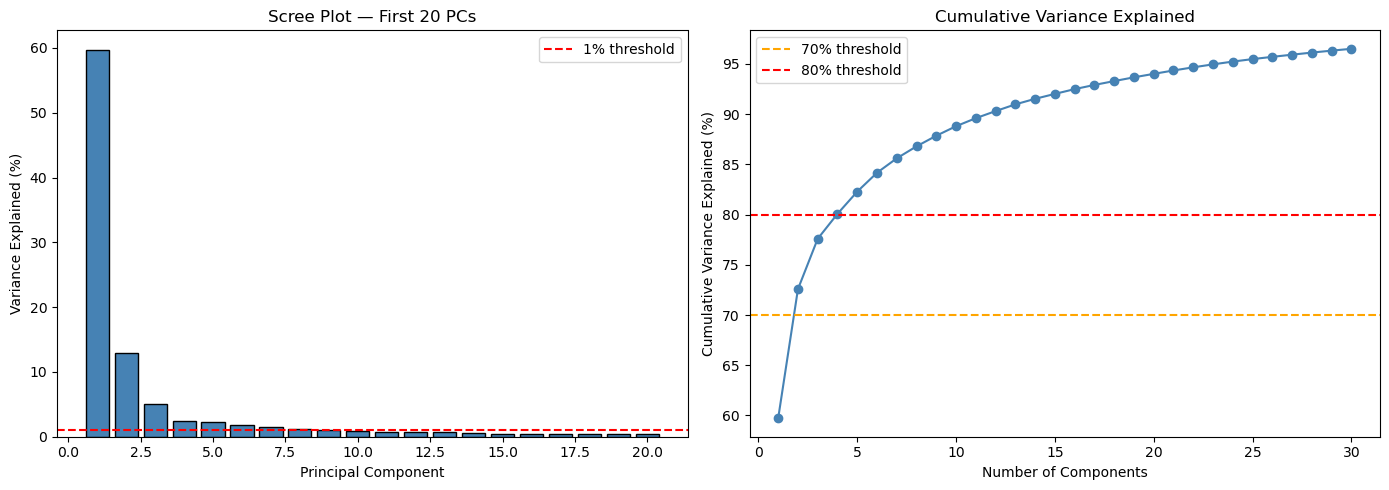

PC   Variance(%)   Cumulative(%)
PC 1      59.72         59.72
PC 2      12.86         72.58
PC 3       5.01         77.59
PC 4       2.48         80.08
PC 5       2.21         82.29
PC 6       1.88         84.16
PC 7       1.44         85.60
PC 8       1.19         86.79
PC 9       1.06         87.85
PC10       0.95         88.80
PC11       0.80         89.60
PC12       0.70         90.30
PC13       0.67         90.97
PC14       0.55         91.53
PC15       0.49         92.02
PC16       0.48         92.49
PC17       0.42         92.91
PC18       0.38         93.29
PC19       0.37         93.67
PC20       0.34         94.01


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120
5g,-0.012543,0.170547,0.145864,-0.103957,0.093406,-0.028363,-0.087450,0.092002,0.050095,0.051004,...,-0.055995,-0.052070,0.115620,-0.028223,-0.124158,-0.001864,0.056816,0.120102,0.065668,0.266252
advertising,0.092837,-0.068646,-0.084000,0.012916,0.001796,-0.053991,-0.004420,0.023668,0.012619,0.020037,...,-0.033253,0.022237,0.002721,-0.218881,-0.044121,0.139723,-0.024011,-0.048622,-0.063055,0.202269
aerospace,0.095632,0.030671,-0.030954,0.048028,-0.048198,0.001953,-0.034926,-0.079294,-0.062269,-0.024953,...,0.095949,0.010603,0.043648,-0.058801,-0.064601,-0.122962,-0.026026,0.010110,-0.019778,0.026660
airlines,0.093477,-0.053153,0.026761,-0.036661,-0.096845,0.052557,0.083067,-0.007102,0.010128,-0.002363,...,0.018266,0.041289,-0.098523,-0.060492,-0.075224,0.080599,0.071151,0.252989,0.033766,0.103751
aluminum,0.100374,-0.002328,0.030788,-0.014062,-0.009247,-0.044095,-0.001297,0.007404,0.013790,-0.001217,...,0.104995,0.039853,-0.057369,0.268257,0.012736,0.023406,-0.203123,0.042889,0.028394,0.035784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
waste management,0.081839,0.000799,0.023005,-0.048099,-0.048380,0.026434,0.065256,-0.043691,-0.070394,-0.149696,...,-0.006352,0.056705,0.015793,-0.047226,0.058298,0.021205,-0.002177,0.076485,0.034341,0.056304
water bill,0.082402,0.112034,0.059049,-0.060362,-0.033218,0.055448,-0.044985,0.003507,-0.023076,-0.032639,...,0.094778,0.039765,0.099088,-0.070795,0.054065,-0.005307,-0.203102,0.016513,0.045483,-0.093977
weight loss,0.095877,0.011918,0.005302,-0.034378,-0.094206,-0.057472,0.040221,0.043027,0.011192,-0.132453,...,-0.064310,-0.086660,-0.218432,-0.000006,0.018948,-0.225032,-0.059103,-0.119427,-0.049260,0.165724
wireless,0.081750,-0.119404,0.002761,0.027788,0.040185,0.088181,0.020640,0.023226,0.051676,-0.030247,...,0.043619,-0.110741,0.042380,0.064468,0.055753,-0.104498,0.104239,-0.020917,-0.124799,-0.104244


In [109]:
out = run_pca_with_scree(df_monthly)
loadings = out["loadings"]
loadings

In [110]:
# Get PC scores and merge with returns
pc_scores_monthly = get_pc_scores(out, df_monthly, n_components=10, freq="M")
df_merged_monthly = align_pc_returns(pc_scores_monthly, returns, freq="M")

# In-sample regression
sectors = list(tickers.values())
pc_cols = [f'PC{i+1}' for i in range(10)]

insample_monthly = run_insample_regression(df_merged_monthly, sectors, pc_cols)
print_significant_coefficients(insample_monthly, sectors, pc_cols)

PC scores:  (120, 10)
Returns:    (90, 12)
Merged:     (90, 22)
Date range: 2018-07-01 to 2025-12-01
IN-SAMPLE R² BY SECTOR
Sector                            R² t+1    R² t+2
--------------------------------------------------
Energy                             0.095     0.122
Materials                          0.094     0.136
Industrials                        0.104     0.101
Consumer Discretionary             0.076     0.084
Consumer Staples                   0.062     0.078
Health Care                        0.037     0.082
Financials                         0.089     0.115
Information Technology             0.074     0.118
Communication Services             0.132     0.155
Utilities                          0.029     0.061
Real Estate                        0.047     0.085
S&P 500                            0.073     0.100

SIGNIFICANT PC COEFFICIENTS (p < 0.1)

Energy
PC        Coef t+1   p t+1  Coef t+2   p t+2        Signal
--------------------------------------------------------

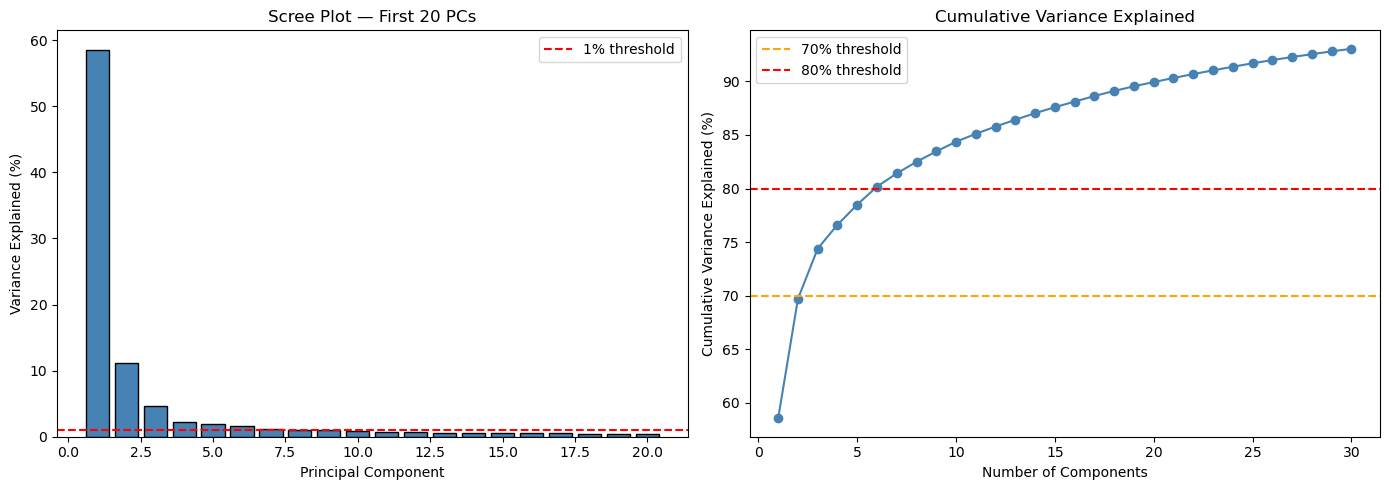

PC   Variance(%)   Cumulative(%)
PC 1      58.57         58.57
PC 2      11.14         69.71
PC 3       4.69         74.40
PC 4       2.22         76.62
PC 5       1.88         78.50
PC 6       1.68         80.18
PC 7       1.23         81.41
PC 8       1.09         82.50
PC 9       0.97         83.46
PC10       0.91         84.37
PC11       0.73         85.10
PC12       0.68         85.78
PC13       0.63         86.42
PC14       0.62         87.03
PC15       0.55         87.59
PC16       0.52         88.11
PC17       0.52         88.63
PC18       0.48         89.11
PC19       0.43         89.54
PC20       0.40         89.93


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC162,PC163,PC164,PC165,PC166,PC167,PC168,PC169,PC170,PC171
5g,-0.013000,0.169053,-0.158673,0.110205,0.025182,0.097885,-0.070984,-0.051764,0.066913,-0.018468,...,-0.013526,0.021948,0.010338,-0.017335,-0.014349,-0.002139,0.029703,0.020800,-0.009543,0.000000e+00
advertising,0.090046,-0.053976,0.104897,0.033265,0.037334,-0.027046,-0.005972,-0.010175,0.023958,0.019420,...,-0.065546,-0.307599,0.038596,-0.036491,-0.017953,-0.103000,0.001800,-0.020423,-0.039371,-1.628087e-16
aerospace,0.089808,0.047207,0.047913,-0.055888,0.038556,-0.057851,-0.025600,0.023907,-0.035151,-0.018237,...,0.032331,0.023319,-0.027281,-0.007023,-0.016090,0.022880,-0.035379,0.007074,0.013565,3.542300e-17
airlines,0.089359,-0.051453,-0.025581,-0.018903,-0.103418,-0.027421,0.084901,0.001149,-0.017599,-0.035371,...,-0.032540,0.021984,0.002899,0.003228,0.005654,-0.013421,-0.001002,0.028377,-0.004148,1.307547e-17
aluminum,0.097739,0.005396,-0.024180,0.022572,0.010172,-0.024035,-0.003403,-0.036816,-0.000353,0.001446,...,0.056754,0.099647,-0.174019,-0.154138,-0.046771,-0.023299,-0.078466,0.032016,-0.029650,-1.530998e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wells fargo,0.079608,-0.134602,0.001996,-0.005472,0.013182,-0.006715,0.008001,0.017285,-0.002832,0.015387,...,0.061986,0.031970,-0.085807,-0.323093,-0.298813,0.089212,0.092037,-0.140729,0.053895,9.676982e-18
wireless,0.081853,-0.116339,0.005071,-0.056787,-0.006052,0.092475,-0.008743,-0.009568,0.004132,0.049583,...,-0.114705,-0.190658,0.074338,-0.042290,-0.253755,-0.309127,0.094362,-0.116335,-0.068805,-1.533951e-16
youtube,0.084255,-0.081394,0.044254,-0.041594,-0.010503,0.036466,-0.005990,-0.035372,0.027872,-0.006091,...,0.245685,-0.012634,-0.206769,-0.301325,0.013916,-0.280349,-0.119838,-0.070765,-0.050217,7.881294e-17
zillow,0.091140,-0.020112,-0.115099,0.057696,-0.025334,-0.083318,0.022350,-0.008664,-0.047525,-0.001536,...,-0.297053,-0.368111,-0.149843,0.359864,-0.176605,-0.160718,-0.230010,0.084031,-0.077789,6.533138e-17


In [111]:
out = run_pca_with_scree(df_weekly)
loadings_weekly = out["loadings"]
loadings_weekly

In [112]:
# Get PC scores and merge with returns
pc_scores_weekly = get_pc_scores(out, df_weekly, n_components=10, freq="W")
df_merged_weekly = align_pc_returns(pc_scores_weekly, returns_weekly, freq="W")

# In-sample regression
sectors = list(tickers.values())
pc_cols = [f'PC{i+1}' for i in range(10)]

insample_weekly = run_insample_regression(df_merged_weekly, sectors, pc_cols)
print_significant_coefficients(insample_weekly, sectors, pc_cols)

PC scores:  (523, 10)
Returns:    (786, 12)
Merged:     (785, 22)
Date range: 2018-06-18 to 2025-12-22
IN-SAMPLE R² BY SECTOR
Sector                            R² t+1    R² t+2
--------------------------------------------------
Energy                             0.017     0.009
Materials                          0.028     0.005
Industrials                        0.031     0.005
Consumer Discretionary             0.040     0.009
Consumer Staples                   0.024     0.005
Health Care                        0.022     0.006
Financials                         0.034     0.006
Information Technology             0.029     0.008
Communication Services             0.026     0.025
Utilities                          0.011     0.004
Real Estate                        0.019     0.006
S&P 500                            0.038     0.006

SIGNIFICANT PC COEFFICIENTS (p < 0.1)

Energy
PC        Coef t+1   p t+1  Coef t+2   p t+2        Signal
------------------------------------------------------

## In-Sample R^2 Results + Analysis

In [115]:
def compare_insample(
    results_dict: dict,
    sectors: list[str],
    horizons_per_result: dict | None = None,
    plot_title: str = "In-Sample R² Comparison",
) -> pd.DataFrame:
    """
    Creates a side-by-side comparison of in-sample R² across datasets.
    
    results_dict: {"Monthly": insample_monthly, "Weekly t+4/t+8": insample_weekly_monthly_equiv}
    horizons_per_result: {"Monthly": [1, 2], "Weekly t+4/t+8": [4, 8]}
        If None, defaults to [1, 2] for all.
    """
    # Default horizons
    if horizons_per_result is None:
        horizons_per_result = {label: [1, 2] for label in results_dict.keys()}

    # Get horizon labels for plot — use first dataset's horizons as reference
    first_label = list(results_dict.keys())[0]
    ref_horizons = horizons_per_result[first_label]
    horizon_labels = [f"~{h} period(s) ahead" for h in ref_horizons]

    rows = []
    for sector in sectors:
        row = {"Sector": sector}
        for label, results in results_dict.items():
            horizons = horizons_per_result[label]
            for h in horizons:
                col = f"{label} t+{h}"
                row[col] = round(results[h][sector].rsquared, 3)
        rows.append(row)

    df_compare = pd.DataFrame(rows).set_index("Sector")

    # ── Plot heatmap ──────────────────────────────────────────────────────────
    n_horizons = len(ref_horizons)
    fig, axes = plt.subplots(1, n_horizons, figsize=(7 * n_horizons, 6))
    if n_horizons == 1:
        axes = [axes]

    for i, (ref_h, horizon_label) in enumerate(zip(ref_horizons, horizon_labels)):
        # Get columns for this horizon position
        cols = []
        col_labels = []
        for label, results in results_dict.items():
            h = horizons_per_result[label][i]
            cols.append(f"{label} t+{h}")
            col_labels.append(f"{label}\n(t+{h})")

        data = df_compare[cols]

        im = axes[i].imshow(data.values, cmap="YlOrRd", aspect="auto", vmin=0, vmax=0.25)
        axes[i].set_xticks(range(len(cols)))
        axes[i].set_xticklabels(col_labels, fontsize=9)
        axes[i].set_yticks(range(len(sectors)))
        axes[i].set_yticklabels(sectors)
        axes[i].set_title(f"R² at {horizon_label}")

        for row in range(len(sectors)):
            for col in range(len(cols)):
                axes[i].text(col, row, f"{data.values[row, col]:.3f}",
                           ha="center", va="center", fontsize=9)

        plt.colorbar(im, ax=axes[i])

    plt.suptitle(plot_title, fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

    return df_compare

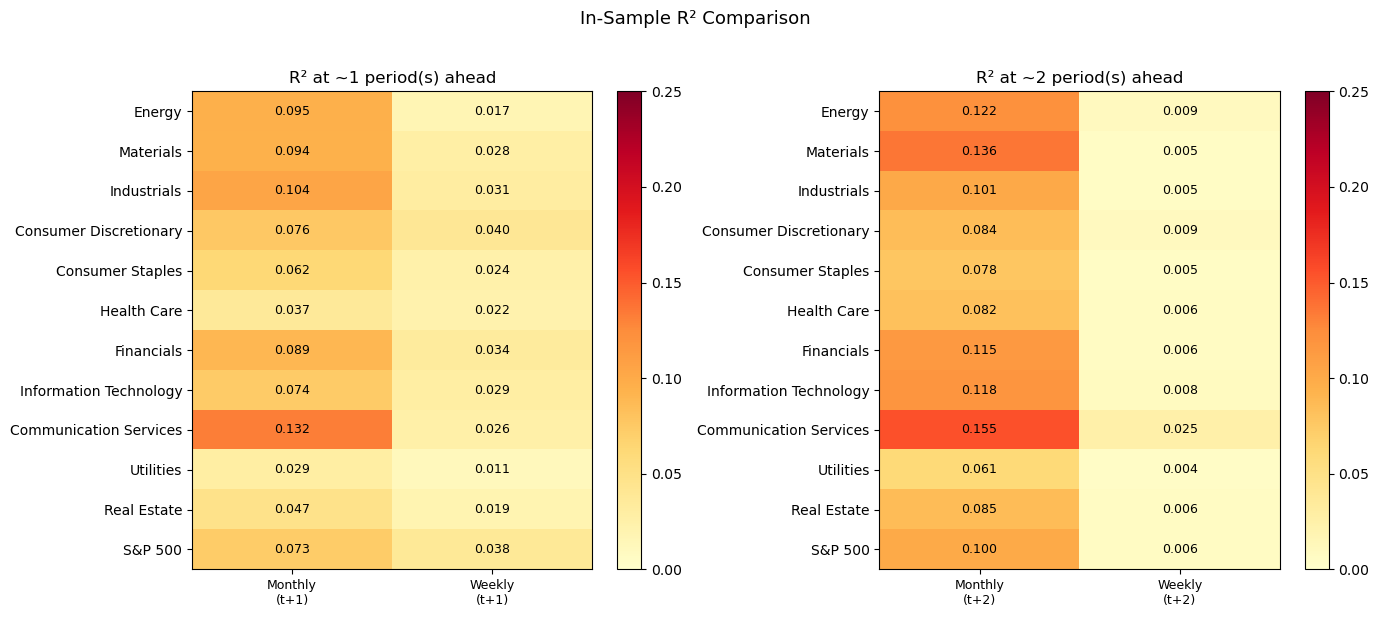

,Monthly t+1,Monthly t+2,Weekly t+1,Weekly t+2
Sector,,,,
Energy,0.095,0.122,0.017,0.009
Materials,0.094,0.136,0.028,0.005
Industrials,0.104,0.101,0.031,0.005
Consumer Discretionary,0.076,0.084,0.040,0.009
Consumer Staples,0.062,0.078,0.024,0.005
Health Care,0.037,0.082,0.022,0.006
Financials,0.089,0.115,0.034,0.006
Information Technology,0.074,0.118,0.029,0.008
Communication Services,0.132,0.155,0.026,0.025


In [117]:
# Run it
df_compare = compare_insample(
    {"Monthly": insample_monthly, "Weekly": insample_weekly},
    sectors
)
df_compare

### Analysis

The R² of 0.132 for Communication Services at t+1 (monthly) means that the 10 PCs together explain 13.2% of the variation in Communication Services returns — the highest of any sector, and even higher at t+2 with 15.5%. 
Basically, investor attention as captured by Google search trends is most closely linked to Communication Services sector returns.

This contrasts with Utilities (0.029) which tells us that Utilities are boring to the average investore. They are defensive and yield-driven stocks that people don't really pay attention to or Google about. Attention factors have almost no predictive power there.


Note: this is one period ahead so t+1 Monthly is one Month ahead and t+1 Weekly is one week ahead

IN-SAMPLE R² BY SECTOR
Sector                            R² t+4    R² t+8
--------------------------------------------------
Energy                             0.009     0.011
Materials                          0.009     0.009
Industrials                        0.008     0.009
Consumer Discretionary             0.010     0.011
Consumer Staples                   0.004     0.014
Health Care                        0.006     0.008
Financials                         0.008     0.007
Information Technology             0.007     0.010
Communication Services             0.015     0.018
Utilities                          0.002     0.003
Real Estate                        0.006     0.006
S&P 500                            0.007     0.009


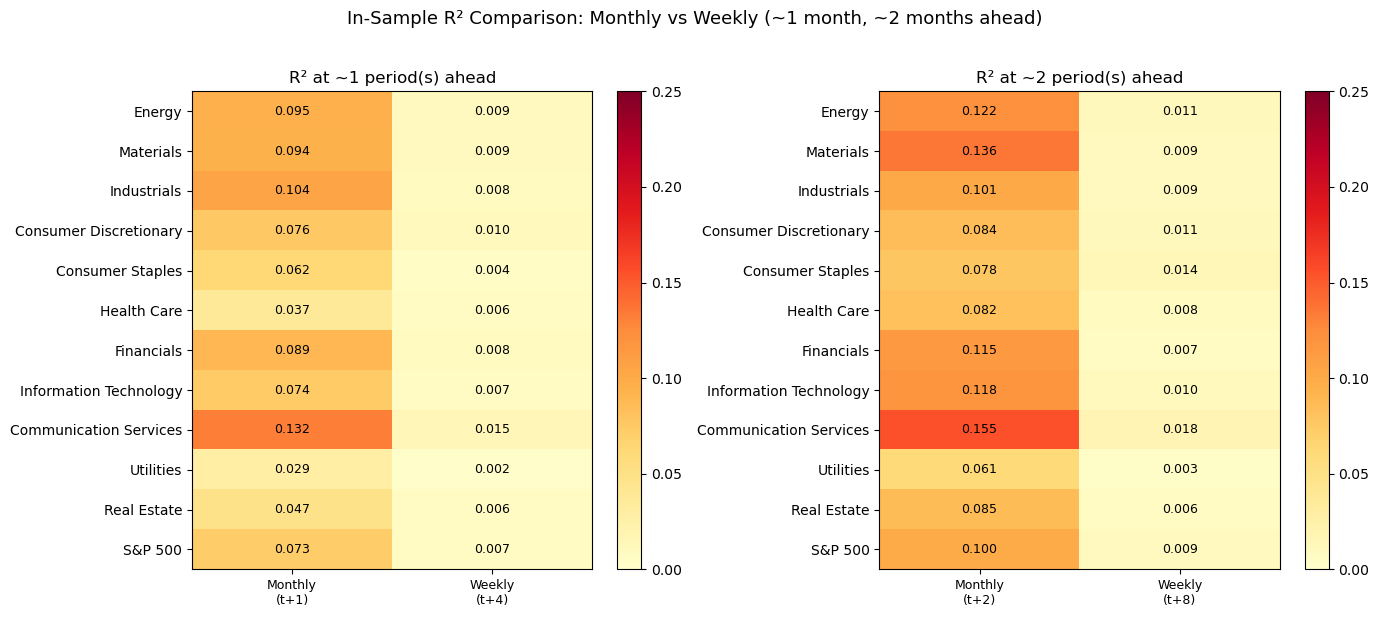

,Monthly t+1,Monthly t+2,Weekly t+4,Weekly t+8
Sector,,,,
Energy,0.095,0.122,0.009,0.011
Materials,0.094,0.136,0.009,0.009
Industrials,0.104,0.101,0.008,0.009
Consumer Discretionary,0.076,0.084,0.010,0.011
Consumer Staples,0.062,0.078,0.004,0.014
Health Care,0.037,0.082,0.006,0.008
Financials,0.089,0.115,0.008,0.007
Information Technology,0.074,0.118,0.007,0.010
Communication Services,0.132,0.155,0.015,0.018


In [116]:
# Weekly with monthly-equivalent horizons (4 weeks ≈ 1 month, 8 weeks ≈ 2 months)
insample_weekly_equiv = run_insample_regression(
    df_merged_weekly, sectors, pc_cols, horizons=[4, 8]
)

# Compare monthly t+1/t+2 vs weekly t+4/t+8
df_compare_equiv = compare_insample(
    results_dict={
        "Monthly": insample_monthly,
        "Weekly":  insample_weekly_equiv,
    },
    sectors=sectors,
    horizons_per_result={
        "Monthly": [1, 2],
        "Weekly":  [4, 8],
    },
    plot_title="In-Sample R² Comparison: Monthly vs Weekly (~1 month, ~2 months ahead)"
)
df_compare_equiv

### Analysis

This is different than above because I use weekly to calculate monthly. So now, we are comparing monthly monthly with weekly monthly. 

This gives us insight suggests that monthly data dramatically outperforms weekly data at the same calendar horizon across every single sector. Monthly R² values are roughly 10x higher than weekly equivalents. 


## OOS Testing

In [123]:
# OOS

def run_oos_rolling(
    df_merged: pd.DataFrame,
    sectors: list[str],
    pc_cols: list[str],
    horizon: int = 1,
    window: int = 36,
) -> dict:
    """
    Rolling window OOS test across all models.
    Returns dict of {model_name: {sector: {oos_r2, msfe_ratio, beats_benchmark}}}
    """

    # ── Model definitions ─────────────────────────────────────────────────────
    alphas = [0.01, 0.1, 1, 10, 100, 1000]
    tscv = TimeSeriesSplit(n_splits=5)  # time-series aware CV

    def get_models():
        return {
            "OLS": None,  # handled separately
            "Ridge":      RidgeCV(alphas=alphas, cv=tscv),
            "Lasso":      LassoCV(alphas=alphas, cv=tscv, max_iter=10000),
            "ElasticNet": ElasticNetCV(
                              alphas=alphas, cv=tscv, max_iter=10000,
                              l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 1.0]
                          ),
            "RandomForest": RandomForestRegressor(
                                n_estimators=100,
                                max_depth=3,        # shallow to prevent overfit
                                min_samples_leaf=5,
                                random_state=42
                            ),
            "XGBoost": XGBRegressor(
                           n_estimators=100,
                           max_depth=3,
                           learning_rate=0.05,
                           subsample=0.8,
                           colsample_bytree=0.8,
                           random_state=42,
                           verbosity=0
                       ),
        }

    model_names = list(get_models().keys())
    results = {m: {} for m in model_names}

    for sector in sectors:
        y_all = df_merged[sector].shift(-horizon).dropna()
        X_all = df_merged[pc_cols].loc[y_all.index]
        common_idx = y_all.index.intersection(X_all.index)
        y_all = y_all.loc[common_idx]
        X_all = X_all.loc[common_idx]

        # Storage per model
        preds = {m: [] for m in model_names}
        y_true_list = []

        for i in range(window, len(y_all)):
            X_train = X_all.iloc[i-window:i].values
            y_train = y_all.iloc[i-window:i].values
            X_test  = X_all.iloc[i].values.reshape(1, -1)
            y_true  = y_all.iloc[i]
            y_true_list.append(y_true)

            # Standardize
            scaler_roll = StandardScaler()
            X_tr_s = scaler_roll.fit_transform(X_train)
            X_te_s = scaler_roll.transform(X_test)

            models = get_models()
            for name, model in models.items():
                if name == "OLS":
                    # Simple OLS via least squares
                    X_ols = np.column_stack([np.ones(len(X_tr_s)), X_tr_s])
                    coef, *_ = np.linalg.lstsq(X_ols, y_train, rcond=None)
                    pred = (np.array([1] + list(X_te_s[0])) @ coef)
                else:
                    model.fit(X_tr_s, y_train)
                    pred = model.predict(X_te_s)[0]
                preds[name].append(pred)

        y_true_arr = np.array(y_true_list)
        benchmark  = np.array([
            y_all.iloc[i-window:i].mean()
            for i in range(window, len(y_all))
        ])
        msfe_bench = np.mean((y_true_arr - benchmark) ** 2)

        for name in model_names:
            y_pred_arr = np.array(preds[name])
            msfe_model = np.mean((y_true_arr - y_pred_arr) ** 2)
            msfe_ratio = msfe_model / msfe_bench
            oos_r2     = r2_score(y_true_arr, y_pred_arr)
            results[name][sector] = {
                "oos_r2":          round(oos_r2, 4),
                "msfe_ratio":      round(msfe_ratio, 4),
                "beats_benchmark": msfe_ratio < 1,
            }

    return results


def print_oos_results(
    results: dict,
    sectors: list[str],
    horizon: int = 1,
    window: int = 36,
) -> pd.DataFrame:
    """Print and return OOS results as a DataFrame."""

    rows = []
    for model_name, sector_results in results.items():
        beats = sum(1 for r in sector_results.values() if r["beats_benchmark"])
        print(f"\n{'='*70}")
        print(f"MODEL: {model_name} | Window: {window} | Horizon: t+{horizon}")
        print(f"{'Sector':<30} {'OOS R²':>8} {'MSFE Ratio':>12} {'Beats':>8}")
        print("-" * 70)
        for sector, res in sector_results.items():
            beat = "✓" if res["beats_benchmark"] else "✗"
            print(f"{sector:<30} {res['oos_r2']:>8.4f} {res['msfe_ratio']:>12.4f} {beat:>8}")
            rows.append({
                "Model": model_name,
                "Sector": sector,
                "OOS R²": res["oos_r2"],
                "MSFE Ratio": res["msfe_ratio"],
                "Beats": res["beats_benchmark"],
            })
        print(f"Beats benchmark: {beats}/{len(sectors)} sectors")

    return pd.DataFrame(rows)


def plot_oos_heatmap(df_oos: pd.DataFrame) -> None:
    """Plot MSFE ratio heatmap across models and sectors."""
    pivot = df_oos.pivot(index="Sector", columns="Model", values="MSFE Ratio")

    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(pivot.values, cmap="RdYlGn_r", aspect="auto", vmin=0.9, vmax=1.15)

    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns, rotation=15)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_title("OOS MSFE Ratio by Model and Sector\n(green < 1 = beats benchmark)")

    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            val = pivot.values[i, j]
            ax.text(j, i, f"{val:.3f}", ha="center", va="center", fontsize=8)

    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()


MODEL: OLS | Window: 36 | Horizon: t+1
Sector                           OOS R²   MSFE Ratio    Beats
----------------------------------------------------------------------
Energy                          -1.2945       2.1280        ✗
Materials                       -1.0588       1.9507        ✗
Industrials                     -1.0985       2.0221        ✗
Consumer Discretionary          -1.1481       2.0408        ✗
Consumer Staples                -1.1872       2.1049        ✗
Health Care                     -1.5028       2.3877        ✗
Financials                      -1.2039       2.1111        ✗
Information Technology          -1.3932       2.2930        ✗
Communication Services          -1.1544       2.0168        ✗
Utilities                       -1.3199       2.2545        ✗
Real Estate                     -1.0712       1.9774        ✗
S&P 500                         -1.4745       2.3738        ✗
Beats benchmark: 0/12 sectors

MODEL: Ridge | Window: 36 | Horizon: t+1
Sector     

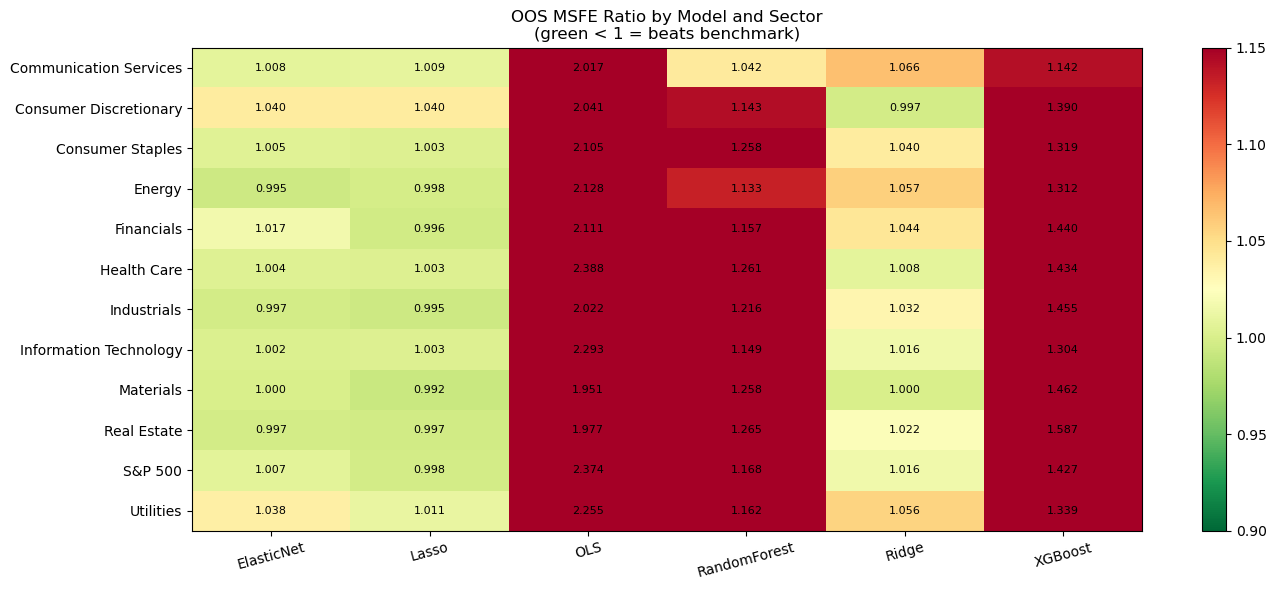

In [124]:
# Monthly t+1
oos_monthly = run_oos_rolling(
    df_merged_monthly, sectors, pc_cols, horizon=1, window=36
)
df_oos_monthly = print_oos_results(oos_monthly, sectors, horizon=1, window=36)
plot_oos_heatmap(df_oos_monthly)


MODEL: OLS | Window: 36 | Horizon: t+2
Sector                           OOS R²   MSFE Ratio    Beats
----------------------------------------------------------------------
Energy                          -1.1392       1.9772        ✗
Materials                       -0.5938       1.5086        ✗
Industrials                     -0.6246       1.5655        ✗
Consumer Discretionary          -0.6541       1.5709        ✗
Consumer Staples                -0.7331       1.6671        ✗
Health Care                     -0.7167       1.6336        ✗
Financials                      -0.5807       1.5121        ✗
Information Technology          -0.7561       1.6798        ✗
Communication Services          -0.5638       1.4595        ✗
Utilities                       -0.6926       1.6432        ✗
Real Estate                     -0.6830       1.6021        ✗
S&P 500                         -0.6587       1.5886        ✗
Beats benchmark: 0/12 sectors

MODEL: Ridge | Window: 36 | Horizon: t+2
Sector     

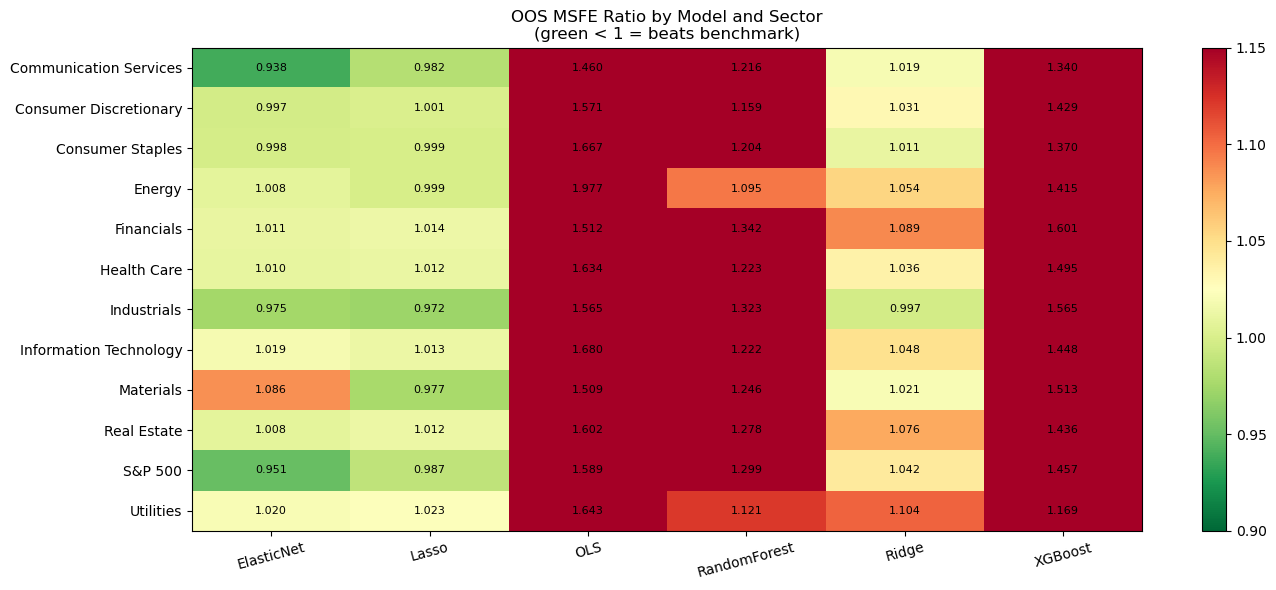

In [125]:
# Monthly t+2
oos_monthly_t2 = run_oos_rolling(
    df_merged_monthly, sectors, pc_cols, horizon=2, window=36
)
df_oos_monthly_t2 = print_oos_results(oos_monthly_t2, sectors, horizon=2, window=36)
plot_oos_heatmap(df_oos_monthly_t2)

In [131]:
# Weekly t+1
oos_weekly = run_oos_rolling(
    df_merged_weekly, sectors, pc_cols, horizon=1, window=156
)
df_oos_weekly = print_oos_results(oos_weekly, sectors, horizon=1, window=156)
plot_oos_heatmap(df_oos_weekly)

KeyboardInterrupt: 

# 5-year weekly 2016-2020

## Cleaning the Data

In [22]:
zero_pct = (trends_2016_pivot == 0).sum() / len(trends_2016_pivot)

print("Zero percentage stats:")
print(zero_pct.describe())

# See how many survive at different zero thresholds
for threshold in [0.50, 0.60, 0.70, 0.80, 0.90]:
    surviving = (zero_pct < threshold).sum()
    print(f"Drop if >{threshold:.0%} zeros: {surviving} keywords survive ({surviving/len(zero_pct)*100:.1f}%)")

Zero percentage stats:
count    1446.000000
mean        0.757602
std         0.406458
min         0.000000
25%         0.612595
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64
Drop if >50% zeros: 351 keywords survive (24.3%)
Drop if >60% zeros: 360 keywords survive (24.9%)
Drop if >70% zeros: 369 keywords survive (25.5%)
Drop if >80% zeros: 388 keywords survive (26.8%)
Drop if >90% zeros: 412 keywords survive (28.5%)


In [23]:
# Apply 70% zero filter
zero_pct = (trends_2016_pivot == 0).sum() / len(trends_2016_pivot)
trends_2016_filtered = trends_2016_pivot.loc[:, zero_pct < 0.70]

print(f"Keywords remaining: {len(trends_2016_filtered.columns)}")

Keywords remaining: 369


In [24]:
keyword_means = trends_2016_filtered.mean()
print(keyword_means.describe())

for threshold in [1, 2, 5, 10, 15, 20]:
    surviving = (keyword_means >= threshold).sum()
    print(f"Mean > {threshold:>2}: {surviving} keywords")

count     369.000000
mean       93.640241
std       338.007193
min         2.600019
25%         9.198171
50%        15.894011
75%        42.655502
max      5154.957527
dtype: float64
Mean >  1: 369 keywords
Mean >  2: 369 keywords
Mean >  5: 348 keywords
Mean > 10: 228 keywords
Mean > 15: 191 keywords
Mean > 20: 150 keywords


In [25]:
keyword_means_clean = trends_2016_filtered.mean()
trends_2016_final = trends_2016_filtered.loc[:, keyword_means_clean >= 15]
print(f"Final dataset shape: {trends_2016_final.shape}")

Final dataset shape: (262, 191)


In [28]:
keyword_means_clean = trends_2016_final.mean()
print(keyword_means_clean.describe())
print("\nTop 10 highest mean keywords:")
print(keyword_means_clean.sort_values(ascending=False).head(10))

count     191.000000
mean      173.040060
std       456.220614
min        15.473720
25%        23.020463
50%        41.151478
75%       124.901933
max      5154.957527
dtype: float64

Top 10 highest mean keywords:
keyword
youtube        5154.957527
movies         2091.894114
oil            1201.762080
restaurants    1198.035969
insurance      1091.573012
netflix        1067.633909
hotels         1046.958563
home depot     1005.170115
airlines        978.327544
disney+         879.487214
dtype: float64


In [40]:
drop_words_2016 = [
    "youtube", "movies", "restaurants", "hotels", 
    "netflix", "home depot", "disney+", "wells fargo", "amazon", "facebook", "twitter", "uber", "airbnb", "bank of america",
    "zillow", "spotify", "comcast", "verizon", "att", "t-mobile", "ford", "gm", "chevrolet", "toyota", "honda",
    "mcdonald's", "starbucks", "coca-cola", "pepsi", "nike", "adidas", "walmart", "costco", "target", "best buy",
    "apple", "samsung", "microsoft", "google", "ibm", "intel", "nvidia", "amd", "tesla", "ford", "gm", "goldman sachs", "jpmorgan", 
    "morgan stanley", "citigroup"
]
drop_words_2016 += [
    "alphabet", "apple iphone", "google search", "tiktok", "redfin", "duke energy", 
    "chevron", "amazon stock", "apple stock", "tesla stock", "walmart grocery", 
    "meta", "exxon", "google stock", "facebook stock", "amd stock", "berkshire hathaway"
]

df_2016_clean = trends_2016_final.drop(columns=[w for w in drop_words_2016 if w in trends_2016_final.columns])
print(f"After manual drops: {df_2016_clean.shape}")

pd.set_option('display.max_rows', None)
print(df_2016_clean.mean().sort_values(ascending=False))

After manual drops: (262, 161)
keyword
oil                       1201.762080
insurance                 1091.573012
airlines                   978.327544
gold                       857.437750
credit card                663.603480
glass                      551.240917
silver                     530.620579
paper                      506.022694
wireless                   486.141154
benefits                   466.241330
real estate                457.467486
steel                      353.187246
software                   343.039818
construction               288.481562
hardware                   272.692035
auto parts                 234.854578
banking                    220.153837
savings                    204.649734
banks                      204.137261
weight loss                188.093977
engineering                185.253260
streaming                  178.809003
sand                       176.658286
podcast                    174.901422
gaming                     169.592615
dow jones  

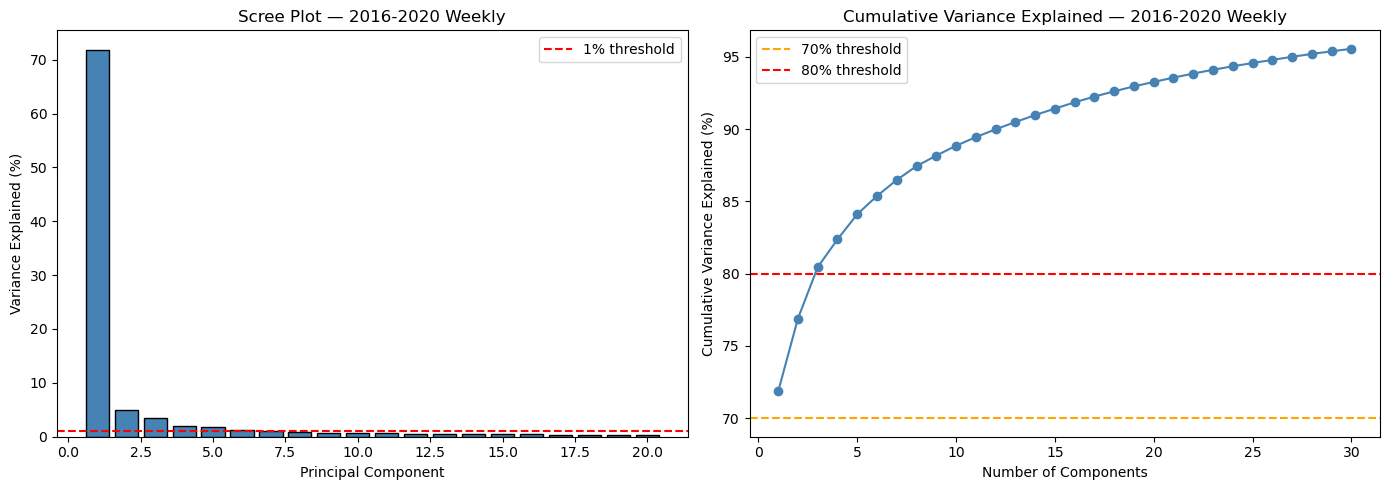

PC   Variance(%)   Cumulative(%)
PC 1      71.85         71.85
PC 2       5.04         76.90
PC 3       3.55         80.45
PC 4       1.92         82.37
PC 5       1.74         84.11
PC 6       1.26         85.37
PC 7       1.11         86.48
PC 8       0.95         87.43
PC 9       0.73         88.17
PC10       0.67         88.84
PC11       0.60         89.44
PC12       0.54         89.98
PC13       0.50         90.48
PC14       0.48         90.96
PC15       0.45         91.41

Top 15 positive loadings — PC1:
keyword
machinery                 0.092007
central bank              0.091978
aluminum                  0.091780
nickel                    0.091724
construction              0.091605
copper                    0.091349
carbon fiber              0.091321
insurance                 0.091252
aerospace                 0.091081
credit cards              0.091066
commercial real estate    0.091065
pharmaceutical            0.091010
bank capital              0.090936
banking              

In [41]:
# Standardize
scaler_2016 = StandardScaler()
X_2016 = scaler_2016.fit_transform(df_2016_clean)

# PCA
pca_2016 = PCA()
pca_2016.fit(X_2016)

explained_2016 = pca_2016.explained_variance_ratio_ * 100
cumulative_2016 = np.cumsum(explained_2016)

# Scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(range(1, 21), explained_2016[:20], color='steelblue', edgecolor='black')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained (%)')
ax1.set_title('Scree Plot — 2016-2020 Weekly')
ax1.axhline(y=1, color='red', linestyle='--', label='1% threshold')
ax1.legend()

ax2.plot(range(1, 31), cumulative_2016[:30], marker='o', color='steelblue')
ax2.axhline(y=70, color='orange', linestyle='--', label='70% threshold')
ax2.axhline(y=80, color='red', linestyle='--', label='80% threshold')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained (%)')
ax2.set_title('Cumulative Variance Explained — 2016-2020 Weekly')
ax2.legend()

plt.tight_layout()
plt.show()

# Variance table
print("PC   Variance(%)   Cumulative(%)")
for i in range(15):
    print(f"PC{i+1:>2}   {explained_2016[i]:>8.2f}      {cumulative_2016[i]:>8.2f}")

# Top loadings PC1 and PC2
loadings_2016 = pd.DataFrame(
    pca_2016.components_.T,
    index=df_2016_clean.columns,
    columns=[f'PC{i+1}' for i in range(len(pca_2016.components_))]
)

print("\nTop 15 positive loadings — PC1:")
print(loadings_2016['PC1'].sort_values(ascending=False).head(15))

print("\nTop 15 positive loadings — PC2:")
print(loadings_2016['PC2'].sort_values(ascending=False).head(15))